## 載入預訓練模型(Xception)

In [1]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Input

# 建立一個輸入張量，指定圖像大小為224x224（RGB色彩通道）
input_tensor = Input(shape=(224, 224, 3))
# 建立 Xception 模型
model = Xception(input_tensor=input_tensor, weights='imagenet', include_top=True)

2023-11-19 21:26:27.014575: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-19 21:26:27.014610: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-19 21:26:27.016244: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-19 21:26:27.024506: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-19 21:26:27.889047: W tensorflow/compiler/tf2

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.xception import preprocess_input

# 載入圖像
image_url = tf.keras.utils.get_file(origin='https://raw.githubusercontent.com/andy6804tw/2023-15th-ironman/main/dataset/cat_dog.jpg')
image = tf.keras.utils.load_img(image_url)
image = tf.keras.utils.img_to_array(image) # 將載入的圖像轉換為數組形式
x = np.expand_dims(image.copy(), axis=0) # 將圖像轉換為模型可接受的維度
# 預處理圖像
x = preprocess_input(x)

In [3]:
from tensorflow.keras.applications.xception import decode_predictions

# 進行圖像分類預測
pred_proba = model.predict(x) # 返回分類機率
# 解析預測結果
pred_class = decode_predictions(pred_proba, top=1)[0][0]  # 解析取得預測結果

1/1 [==============================] - 1s 624ms/step


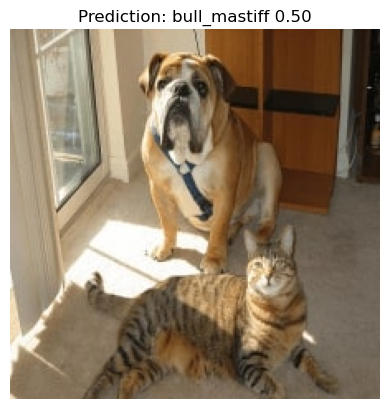

In [4]:
import matplotlib.pylab as plt

plt.imshow(image.astype('uint8'))
plt.axis('off')
predicted_class_name = pred_class[1]
_ = plt.title(f"Prediction: {predicted_class_name} {pred_class[2]:.2f}")

## Grad-CAM 實作

In [5]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 建立一個模型，同時輸出最後一個卷積層和整個模型的預測結果
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # 計算對於輸入圖像的預測類別，相對於最後一個卷積層的梯度
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # 輸出分類神經元相對於最後一個卷積層的輸出特徵圖的梯度
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # 這是一個向量，其中每個數字都是特定特徵圖通道上的梯度的平均強度
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    # 將特徵圖乘以權重，等於該特徵圖中的某些區域對於該分類的重要性
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap) # 然後將所有通道相加以獲得熱圖

    # 為了視覺化，將熱圖正規化0~1之間
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

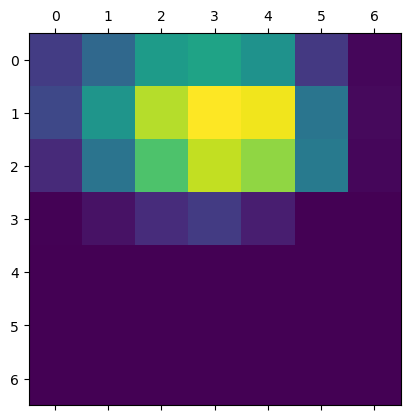

In [6]:
# 產生 class activation heatmap
last_conv_layer_name = "block14_sepconv2_act"
heatmap = make_gradcam_heatmap(x, model, last_conv_layer_name)

# 顯示 heatmap
plt.matshow(heatmap)
plt.show()

In [7]:
import matplotlib.cm as cm
from IPython.display import Image, display

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.5):
    # 載入原始圖像
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    # 將熱圖重新縮放到0-255的範圍
    heatmap = np.uint8(255 * heatmap)

    # 使用Jet色彩映射將熱圖上色
    jet = cm.get_cmap("jet")

    # 使用Jet色彩映射的RGB值
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # 創建帶有RGB色彩的熱圖圖像
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # 在原始圖像上疊加熱圖
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    # 儲存疊加後的圖像
    superimposed_img.save(cam_path)

    # 顯示Grad CAM
    display(Image(cam_path))


/tmp/ipykernel_20715/2132209253.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


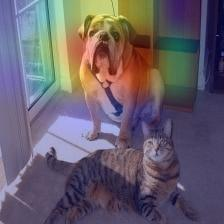

In [9]:
save_and_display_gradcam(image_url, heatmap)